In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
from scipy import ndimage

In [ ]:
IMG_DIR=r'competition_data/train/rendered_images/images'
MASK_DIR=r'competition_data/train/ground_truths/masks'

def adjustData(img,mask):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)



import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle 


train_read = open('competition_data/training_data', "rb")
training_data = pickle.load(train_read)


mask_read=open('competition_data/mask_data', "rb")
mask_data = pickle.load(mask_read)


training_data,mask_data=adjustData(training_data,mask_data)

In [ ]:
X=np.array(training_data)
y=np.array(mask_data)

In [ ]:
X=np.reshape(X,(len(X),128,128,1))
y=np.reshape(y,(len(y),128,128,1))

In [ ]:
print(X.shape)
print(y.shape)

(4000, 128, 128, 1)
(4000, 128, 128, 1)


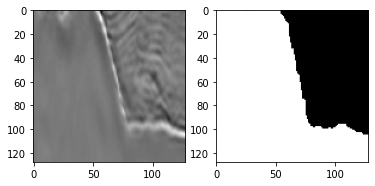

In [ ]:
plt.subplot(121)
plt.imshow(np.squeeze(X[10]),cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(y[10]),cmap='gray')
plt.show()

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input,Dropout,add,BatchNormalization
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam,SGD,Adagrad
from tqdm import tqdm_notebook, tnrange
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import keras

In [ ]:
SM_FRAMEWORK=keras
#!pip3 install tensorflow==2.2
#!pip3 install keras==2.3.1
#!pip3 install -U segmentation-models
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ngayw9ne
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ngayw9ne
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 5.9 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=e33c05a2c95e2aacda6745c88f0fc78d8c2d66a6dd6d84492fa8f4a2f0871ab0
  Stored in directory: /tmp/pip-ephem-wheel-cache-qd34xd8b/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
SM_FRAMEWORK=keras
#tf.keras.backend.set_image_data_format('channels_last')
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
def resnet_block(input,filter_size):
  conv=Conv2D(filter_size,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(input)
  conv=BatchNormalization()(conv)
  conv=Conv2D(filter_size,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv)
  conv=BatchNormalization()(conv)
  conv=Conv2D(filter_size,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv)
  conv=BatchNormalization()(conv)
  conv=add([input,conv])
  return conv



In [ ]:
inputs = Input((128,128,1))
#inputs =Lambda(lambda x:x/255)(inputs)


a=Conv2D(8,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
conv0=BatchNormalization()(a)
conv0=resnet_block(conv0,8)
conv0=Dropout(0.1)(conv0)
pool0=MaxPooling2D((2,2))(conv0)


conv1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool0)
conv1=BatchNormalization()(conv1)
conv1=resnet_block(conv1,16)
conv1=Dropout(0.1)(conv1)
pool1=MaxPooling2D((2,2))(conv1)


conv2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool1)
conv2=BatchNormalization()(conv2)
conv2=resnet_block(conv2,32)
conv2=Dropout(0.1)(conv2)
pool2=MaxPooling2D((2,2))(conv2)


conv3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool2)
conv3=BatchNormalization()(conv3)
conv3=resnet_block(conv3,64)
conv3=Dropout(0.1)(conv3)
pool3=MaxPooling2D((2,2))(conv3)


conv4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool3)
conv4=BatchNormalization()(conv4)
conv4=resnet_block(conv4,128)
conv4=Dropout(0.1)(conv4)
pool4=MaxPooling2D((2,2))(conv4)



#middle block
middle_layer=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool4)
middle_layer=BatchNormalization()(middle_layer)
middle_layer=resnet_block(middle_layer,256)
middle_layer=Dropout(0.1)(middle_layer)
middle_pool=MaxPooling2D((2,2))(middle_layer)


#decoding block


deconv4=Conv2DTranspose(128,(3,3),strides=(2,2),padding='same')(middle_layer)
deconv4=concatenate([deconv4,conv4])
deconv4=Dropout(0.1)(deconv4)
uconv4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(deconv4)
uconv4=BatchNormalization()(uconv4)
uconv4=resnet_block(uconv4,128)
uconv4=Dropout(0.1)(uconv4)


deconv3=Conv2DTranspose(64,(3,3),strides=(2,2),padding='same')(uconv4)
deconv3=concatenate([deconv3,conv3])
deconv3=Dropout(0.1)(deconv3)
uconv3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(deconv3)
uconv3=BatchNormalization()(uconv3)
uconv3=resnet_block(uconv3,64)
uconv3=Dropout(0.1)(uconv3)

deconv2=Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(uconv3)
deconv2=concatenate([deconv2,conv2])
deconv2=Dropout(0.1)(deconv2)
uconv2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(deconv2)
uconv2=BatchNormalization()(uconv2)
uconv2=resnet_block(uconv2,32)
uconv2=Dropout(0.1)(uconv2)


deconv1=Conv2DTranspose(16,(3,3),strides=(2,2),padding='same')(uconv2)
deconv1=concatenate([deconv1,conv1])
deconv1=Dropout(0.1)(deconv1)
uconv1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(deconv1)
uconv1=BatchNormalization()(uconv1)
uconv1=resnet_block(uconv1,16)
uconv1=Dropout(0.1)(uconv1)


deconv0=Conv2DTranspose(8,(3,3),strides=(2,2),padding='same')(uconv1)
deconv0=concatenate([deconv0,conv0])
deconv0=Dropout(0.1)(deconv0)
uconv0=Conv2D(8,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(deconv0)
uconv0=BatchNormalization()(uconv0)
uconv0=resnet_block(uconv0,8)
uconv0=Dropout(0.1)(uconv0)



outputs = Conv2D(1, (1, 1), padding='same',activation='sigmoid')(uconv0)


model = Model(inputs, outputs)
model.compile(optimizer=Adam(1e-2), loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 128, 128, 8)  80          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_44 (BatchN  (None, 128, 128, 8)  32         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                            

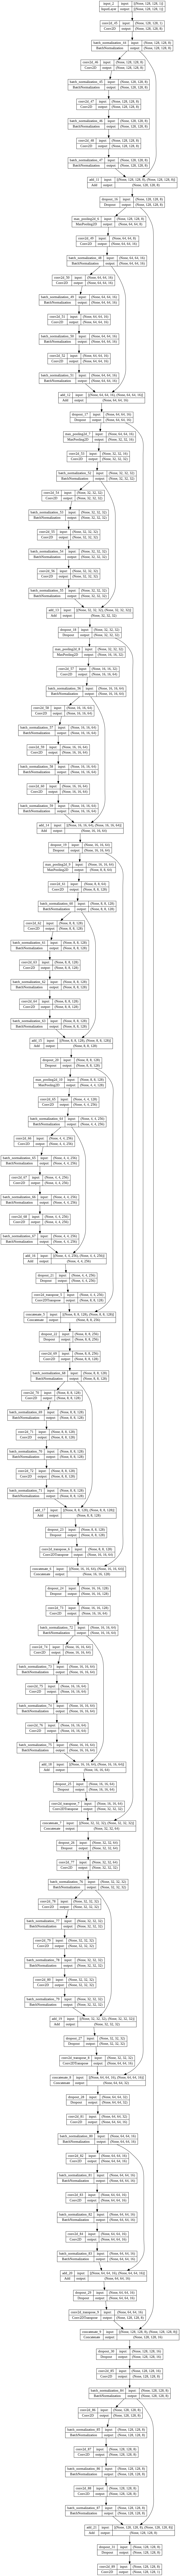

In [ ]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True,to_file="/content/drive/MyDrive/competition_data/model_architecture.png")

In [ ]:
callbacks=[keras.callbacks.ModelCheckpoint(os.path.join('/content/drive/MyDrive/competition_data/','model.h5'),monitor='val_loss',save_weights_only=True,save_best_only=True,mode='min')]

history=model.fit(X,y,batch_size=10, epochs=200,validation_split=0.1,callbacks=callbacks)

Epoch 1/200
360/360 [==============================] - 21s 44ms/step - loss: 0.6525 - iou_score: 0.3003 - val_loss: 0.7741 - val_iou_score: 0.3198
Epoch 2/200
360/360 [==============================] - 16s 44ms/step - loss: 0.5343 - iou_score: 0.4202 - val_loss: 0.5217 - val_iou_score: 0.4466
Epoch 3/200
360/360 [==============================] - 16s 43ms/step - loss: 0.4928 - iou_score: 0.4562 - val_loss: 0.5050 - val_iou_score: 0.4762
Epoch 4/200
360/360 [==============================] - 16s 44ms/step - loss: 0.4601 - iou_score: 0.4865 - val_loss: 0.4526 - val_iou_score: 0.5692
Epoch 5/200
360/360 [==============================] - 15s 42ms/step - loss: 0.4326 - iou_score: 0.5139 - val_loss: 1.4130 - val_iou_score: 0.0034
Epoch 6/200
360/360 [==============================] - 15s 41ms/step - loss: 0.4047 - iou_score: 0.5415 - val_loss: 0.5662 - val_iou_score: 0.3933
Epoch 7/200
360/360 [==============================] - 16s 43ms/step - loss: 0.3810 - iou_score: 0.5603 - val_loss: 0.

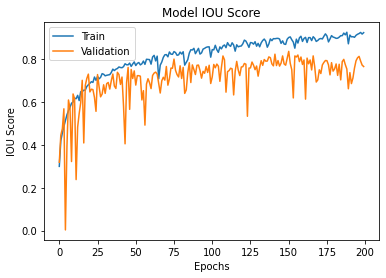

In [ ]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'],loc='best')
plt.savefig('/content/drive/MyDrive/competition_data/IOU_score',dpi=600)
plt.show()

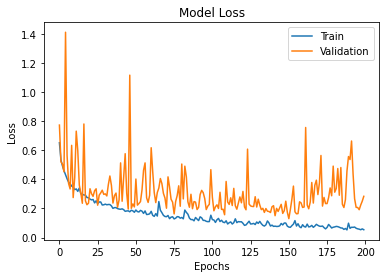

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'],loc='best')
plt.savefig('/content/drive/MyDrive/competition_data/Model_Loss',dpi=600)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/competition_data/myModel.h5')